In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')

import itertools

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Dropout
from keras.models import Model, Sequential
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix,classification_report
import imageio
import matplotlib.image as img

import os 
import pathlib 

from tensorflow.keras.applications import imagenet_utils
import scipy

In [3]:
vgg16NoTopFile='D://Flower_Classification//vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
vgg16=VGG16(include_top=False,input_shape=(224,224,3),weights=vgg16NoTopFile)

In [5]:
#We can extract features from VGG16. Get the features directly from VGG16

In [6]:
# Extract features from images using the VGG16 model
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Shape of the last convolutional layer in VGG16
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg16.predict(inputs_batch)
        features[i * 32 : (i + 1) * 32] = features_batch
        labels[i * 32 : (i + 1) * 32] = np.argmax(labels_batch, axis=1)
        i += 1
        if i * 32 >= sample_count:
            break
    return features, labels

# Specify the directory and the number of samples for feature extraction
train_generator=ImageDataGenerator(rescale = 1./255) 
generator = train_generator.flow_from_directory("D://flower_images",target_size=(224,224),batch_size=32,
                                         class_mode='categorical',
                                         shuffle=True)
train_sample_count = 5000  # Total number of training samples

# Extract features from the training data
train_features, train_labels = extract_features(generator, train_sample_count)


Found 5000 images belonging to 5 classes.
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 1s 712ms/step


In [7]:
path = pathlib.Path("D://flower_images")

In [8]:
lilly = list(path.glob('Lilly/*'))[:1000]
lotus = list(path.glob('Lotus/*'))[:1000]
orchid = list(path.glob('Orchid/*'))[:1000]
sunflower = list(path.glob('Sunflower/*'))[:1000]
tulip = list(path.glob('Tulip/*'))[:1000]

In [9]:
data = {
    'lilly' : lilly,
    'lotus' : lotus,
    'orchid' : orchid,
    'sunflower' : sunflower,
    'tulip': tulip
}
flower_labels= {k:v for k,v in enumerate(data.keys())}

In [10]:
class_names = [i for i in data.keys()]
class_names

['lilly', 'lotus', 'orchid', 'sunflower', 'tulip']

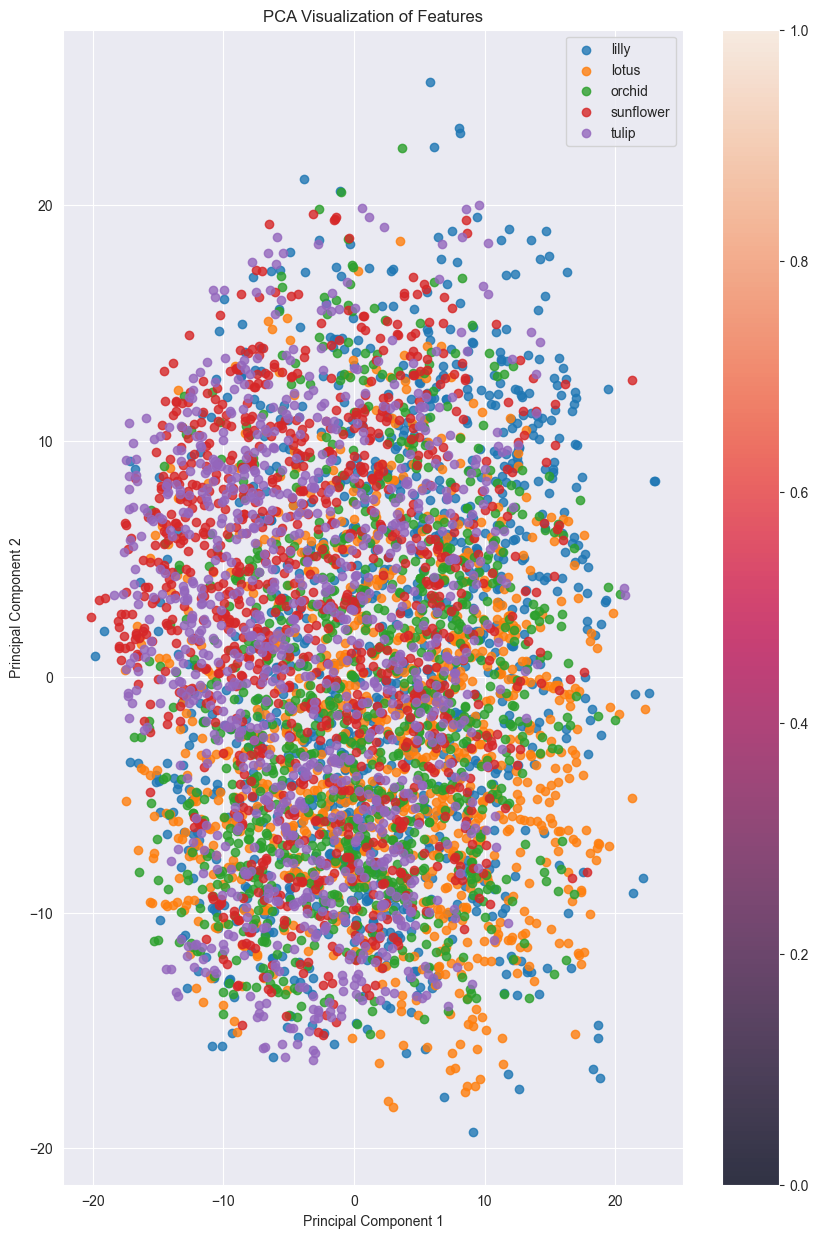

In [11]:
# Flatten the features for PCA
flatten_features = train_features.reshape(train_features.shape[0], -1)

# Apply PCA to the features
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flatten_features)

# Plot the PCA results
plt.figure(figsize=(10,15))
for i, class_name in enumerate(class_names):
    plt.scatter(pca_result[:, 0][train_labels == i][:1000], pca_result[:, 1][train_labels == i][:1000], label = class_name, alpha=0.8)
  #  plt.scatter(pca_result[:, 0], pca_result[:, 1], c=train_labels, alpha=0.6,cmap='hsv')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Visualization of Features')
plt.legend()
plt.colorbar()
plt.show()

In [13]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (7, 7, 512)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, epochs=20,validation_split=0.2)

Epoch 1/20
125/125 [==============================] - 1s 4ms/step - loss: 0.9890 - accuracy: 0.7003 - val_loss: 0.4476 - val_accuracy: 0.8460
Epoch 2/20
125/125 [==============================] - 0s 3ms/step - loss: 0.2656 - accuracy: 0.9230 - val_loss: 0.3326 - val_accuracy: 0.8820
Epoch 3/20
125/125 [==============================] - 0s 3ms/step - loss: 0.1165 - accuracy: 0.9765 - val_loss: 0.2468 - val_accuracy: 0.9180
Epoch 4/20
125/125 [==============================] - 0s 3ms/step - loss: 0.0618 - accuracy: 0.9925 - val_loss: 0.2478 - val_accuracy: 0.9250
Epoch 5/20
125/125 [==============================] - 0s 3ms/step - loss: 0.0413 - accuracy: 0.9950 - val_loss: 0.2315 - val_accuracy: 0.9230
Epoch 6/20
125/125 [==============================] - 0s 3ms/step - loss: 0.0268 - accuracy: 0.9975 - val_loss: 0.2876 - val_accuracy: 0.9080
Epoch 7/20
125/125 [==============================] - 0s 3ms/step - loss: 0.0334 - accuracy: 0.9948 - val_loss: 0.2441 - val_accuracy: 0.9220
Epoch 

In [14]:
def plot(c):
    plt.plot(c.history.history['accuracy'],color='red',markersize=10)
    plt.plot(c.history.history['val_accuracy'],color='green',markersize=10)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()
    plt.plot(c.history.history['loss'],color='red',markersize=10)
    plt.plot(c.history.history['val_loss'],color='green',markersize=10)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

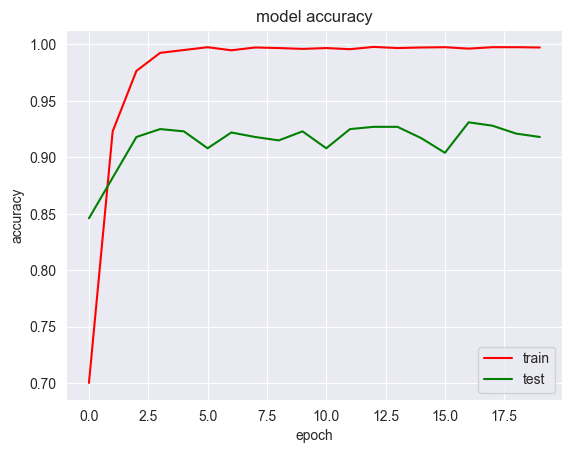

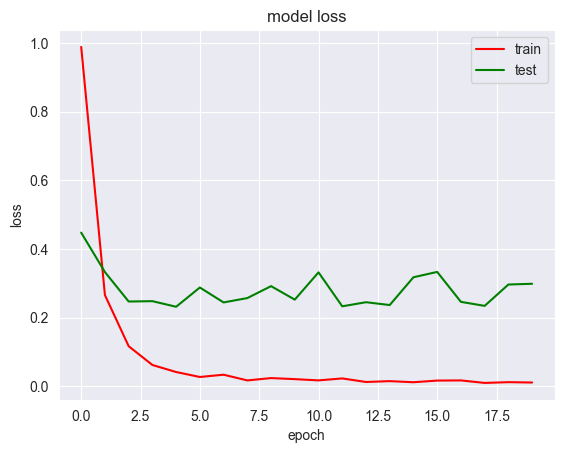

In [15]:
plot(model2)